# 0.0 Helper Functions

In [1]:
#!pip install inflection

In [2]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
# import xgboost as xgb

from scipy                 import stats  as ss
# from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

In [3]:
import datetime

## 0.1 Helper Functions

In [4]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [6]:
df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Descrição dos Dados

## 1.1 Rename Columns

In [7]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
df1 = df_raw.copy()

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

#lib inflection tem o método para ajudar a renomear as colunas usando o método 
#snakecase (com underscore entre as palavras)
snakecase_lambda = lambda x: inflection.underscore(x)

cols_new=list(map(snakecase_lambda,cols_old))

#rename
df1.columns = cols_new

In [10]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [11]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [12]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
df1['date']=pd.to_datetime(df1['date'])

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [15]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Alternatives
* drop NA: apenas se não forem muitas linhas com NA
* usando algoritmos: substituir com mediana, média, previsão do valor
* substituir com inputs manuais: apenas se você tiver o conhecimento do negócio e souber como seria possível substituir esses dados.

## 1.5 Fillout NA

In [16]:
df1['competition_distance'].max()

75860.0

In [17]:
# competition_distance
# adicionar um valor muito acima, pois imagino que o valor está vazio, pois o competidor
# está muito longe que não é considerado.
# a função lambda funciona igual a uma função matemática, tenho um valor que é assumido, dada uma condição
# fazendo "lambda x" eu digo que é uma função de x, que é a variável sendo trabalhada
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month']=df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year 
df1['competition_open_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2                      
# promo2_since_week           
df1['promo2_since_week']=df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year           
df1['promo2_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [18]:
# promo_interval  
month_map={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May', 6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec', }

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

In [19]:
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [20]:
#transpose
df1.sample(5).T

,556868,398071,821782,296624,182820
store,154,1040,813,480,1076
day_of_week,1,6,2,2,3
date,2014-02-17 00:00:00,2014-07-12 00:00:00,2013-06-25 00:00:00,2014-10-28 00:00:00,2015-02-18 00:00:00
sales,13702,6899,4498,4336,4273
customers,1052,674,576,604,620
open,1,1,1,1,1
promo,1,0,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,1,0
store_type,d,a,a,a,a


In [21]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

In [22]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistics

In [23]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Atributes

In [24]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance'>

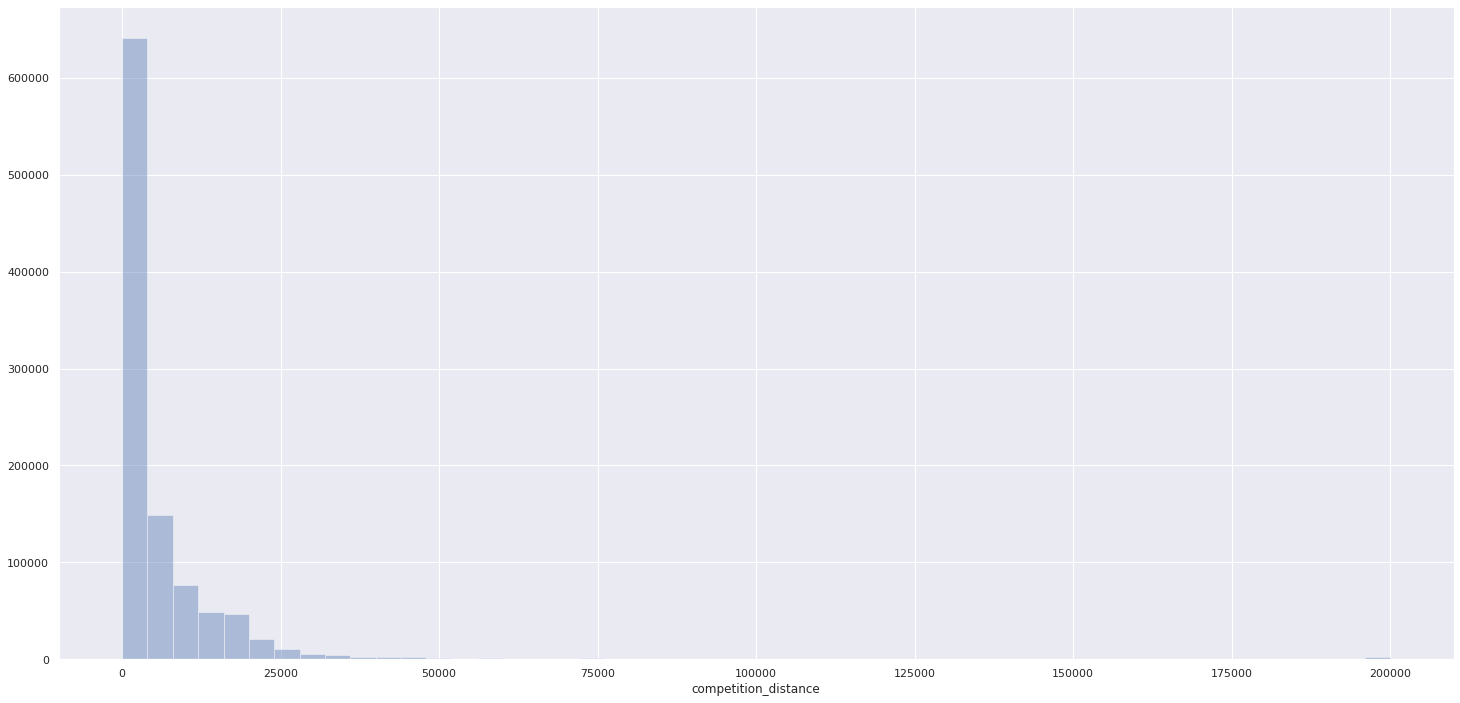

In [25]:
sns.distplot( df1['competition_distance'], kde=False )

### 1.7.2. Categorical Atributes

In [26]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

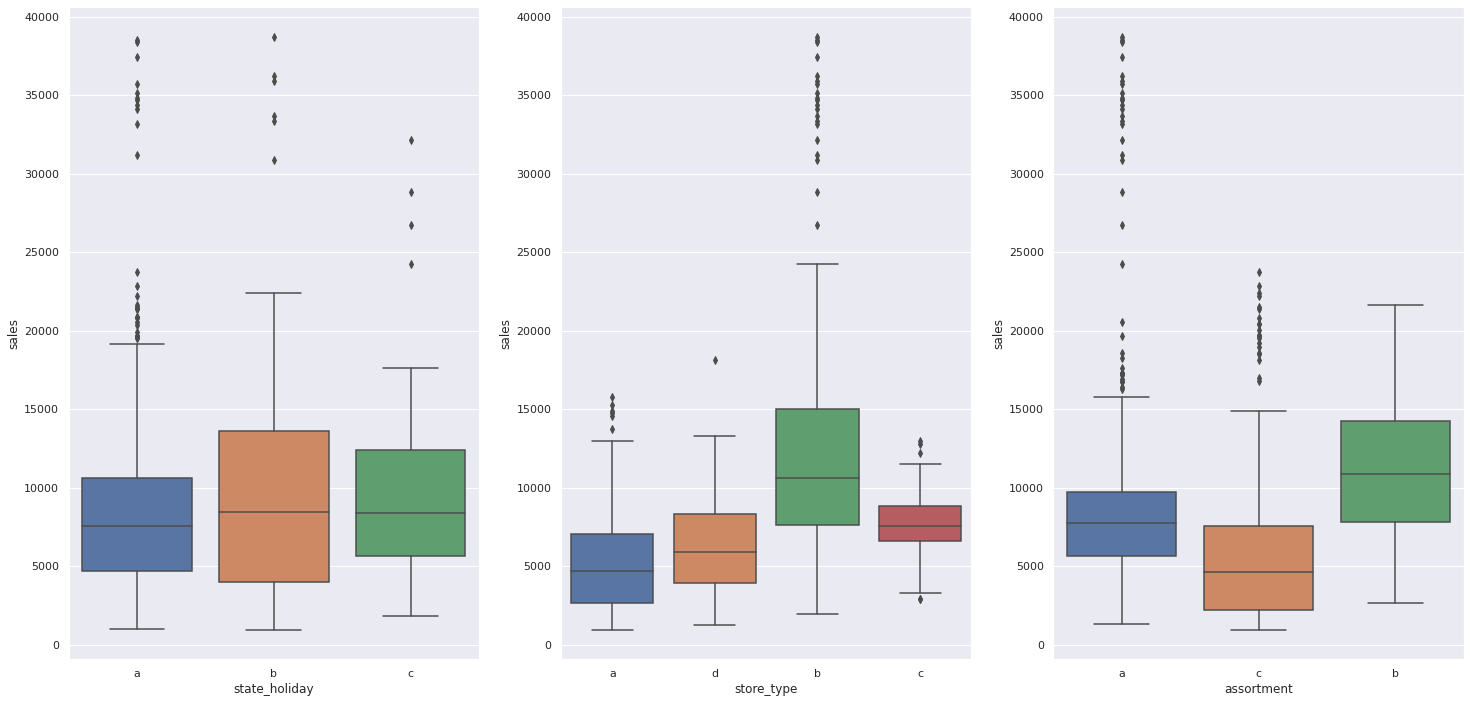

In [27]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0 Feature Engineering

## 2.1 Criação de Hipóteses

*Agente Loja*

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

*Agente Produto*

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

*Agente Tempo (Sazonalidade)*

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

**Priorização de hipóteses**

-Critério principal: disponibilidade imediata do dado

-Outros critérios: ferramentas, investimento necessário etc.

### Hipóteses Selecionadas

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Feature Engineering

In [28]:
df2 = df1.copy()

In [29]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

In [30]:
# year
df2['year'] = df2['date'].dt.year

In [31]:
# month
df2['month'] = df2['date'].dt.month

In [32]:
# day
df2['day'] = df2['date'].dt.day

In [33]:
# week of year
# extracting week from a datetime variable
df2['week_of_year'] = df2['date'].dt.isocalendar().week

In [34]:
# year week
# formatting a variable with part of date
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

In [35]:
# competition since
# creating a datedtime column with datetime.datetime
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=int(x['competition_open_since_year']), month=int(x['competition_open_since_month']),day=1 ), axis=1 )
# subtracting the  new date 'competition_since' from the date and dividing by 30, we have this interval in months
# after that, we convert to days and cast it to int
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

In [36]:
# promo since
# adding the two fields as strings, need to cast as int before to correct the next step
df2['promo_since'] = df2['promo2_since_year'].astype( int ).astype( str ) + '-' + df2['promo2_since_week'].astype( int ).astype( str )
# 
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

In [37]:
# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

In [38]:
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0 Filtragem de Variáveis

In [39]:
df3 = df2.copy()

## 3.1 Filtragem de Linhas

In [40]:
# lojas tem que estar abertas
# lojas tem que ter vendas
df3 = df3[(df3['open'] != 0) & (df3['sales']  > 0)] 

## 3.2 Filtragem de Colunas

In [41]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [42]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EDA - Exploratory Data Analysis

In [43]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Target (Class)
final output you are trying to predict

<AxesSubplot:xlabel='sales', ylabel='Density'>

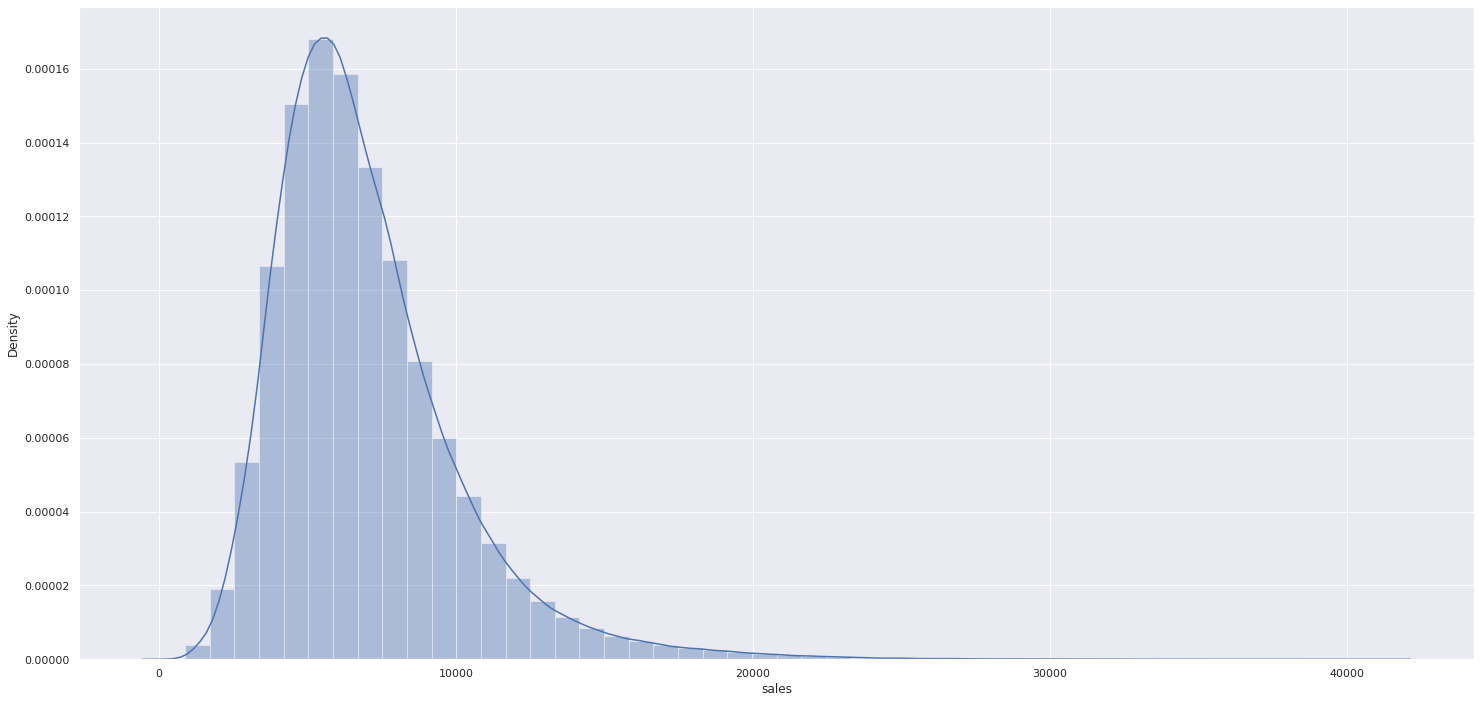

In [44]:
sns.distplot( df4['sales'] )

Algumas das premissas dos modelos de ML é de que os dados sejam:
* Independentes
* Normalmente Distribuidos

Então, como observamos aqui um deslocamento à esquerda dessa distribuição, temos que seria ideal aplicar alguma transformação para deixar a distribuição mais próxima da distribuição normal. Exemplos de transformações são logarítmica ou exponencial.

### 4.1.2 Number Variable

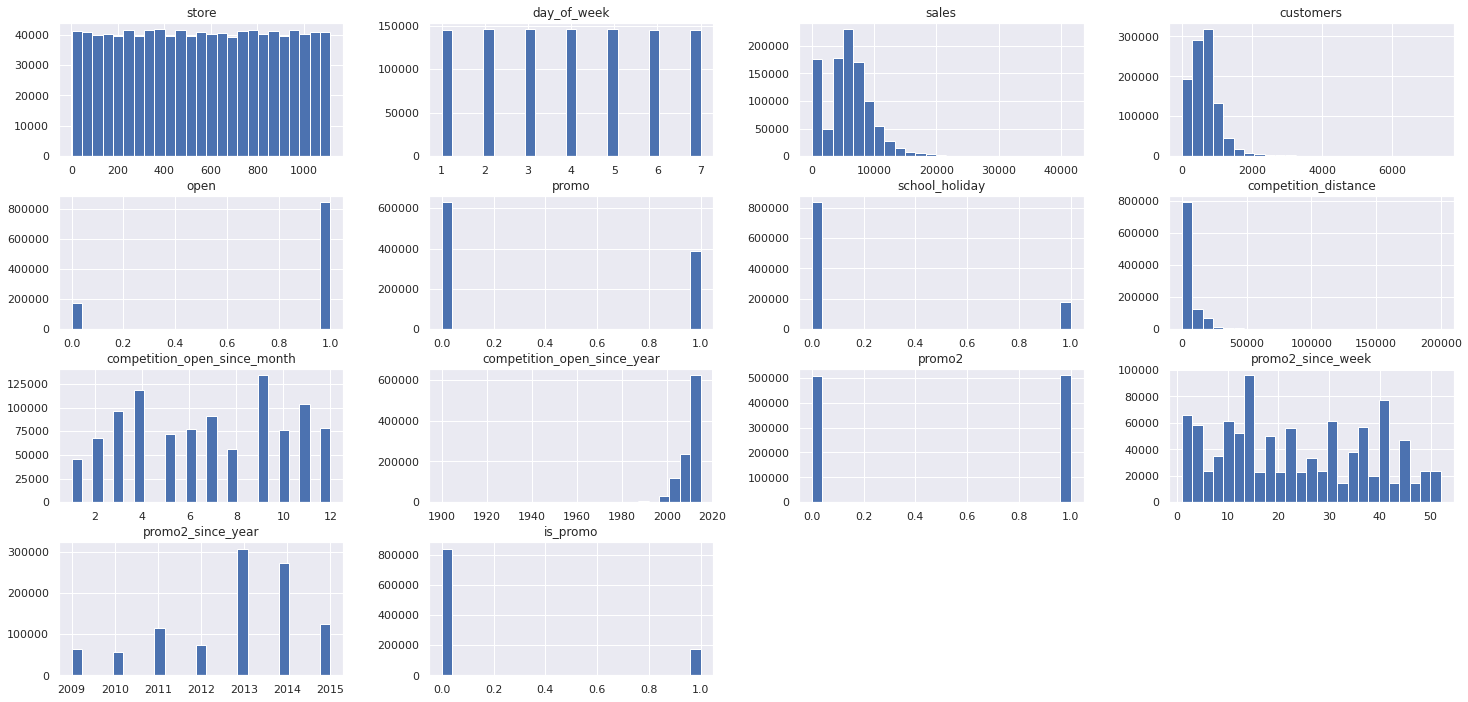

In [45]:
num_attributes.hist( bins= 25 );

### 4.1.3 Category Variable

In [46]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [47]:
df4[ 'state_holiday' ].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [48]:
df4[ 'store_type' ].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [49]:
df4[ 'assortment' ].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

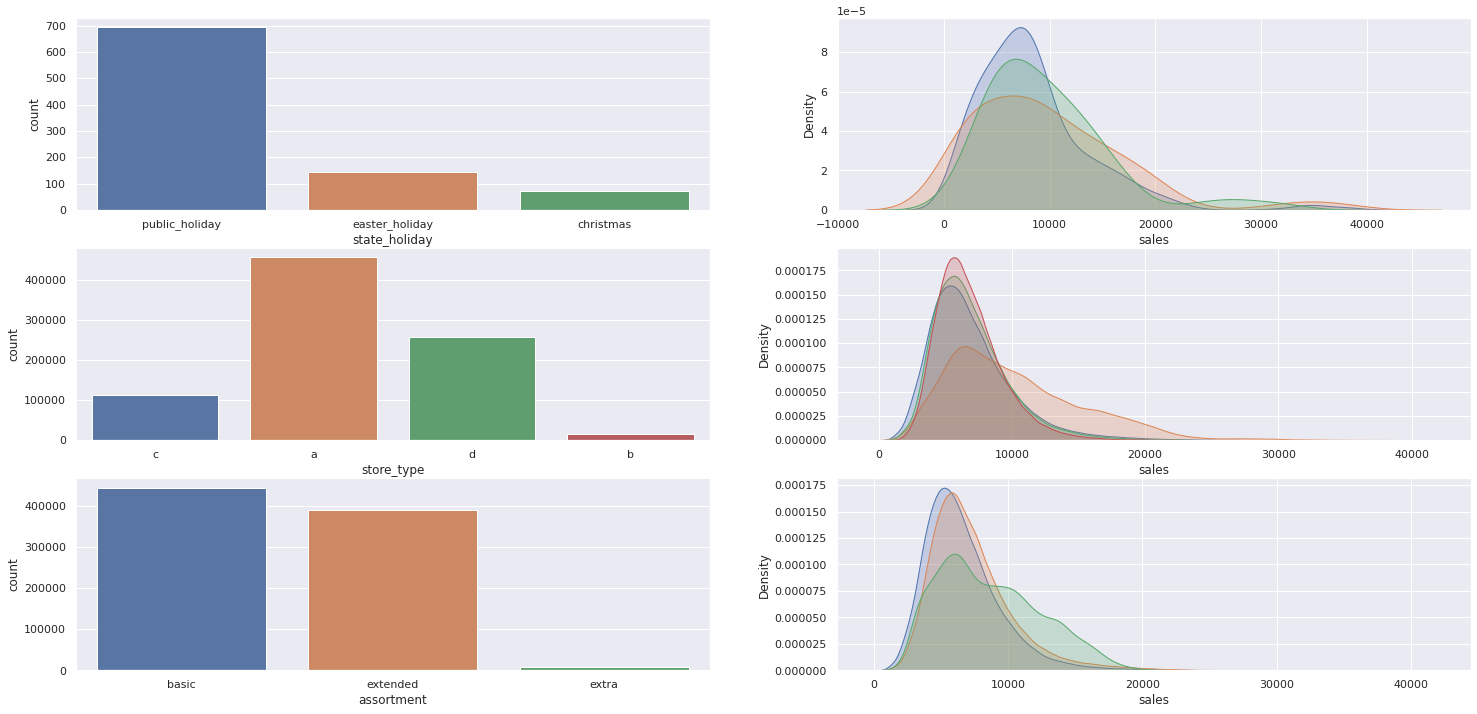

In [50]:
# state_holiday
# preciso filtrar o dias normais pois eles são em muito maior quantidade
a = df4[df4['state_holiday'] != 'regular_day']

# criando um grid matplotlib
plt.subplot( 3, 2, 1 )
sns.countplot( a[ 'state_holiday' ] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade = True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade = True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade = True );

# store_type
# criando um grid matplotlib
plt.subplot( 3, 2, 3 )
sns.countplot( df4[ 'store_type' ] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade = True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade = True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade = True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade = True );

# assortment
# criando um grid matplotlib
plt.subplot( 3, 2, 5 )
sns.countplot( df4[ 'assortment' ] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade = True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade = True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade = True );

## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais
***FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS

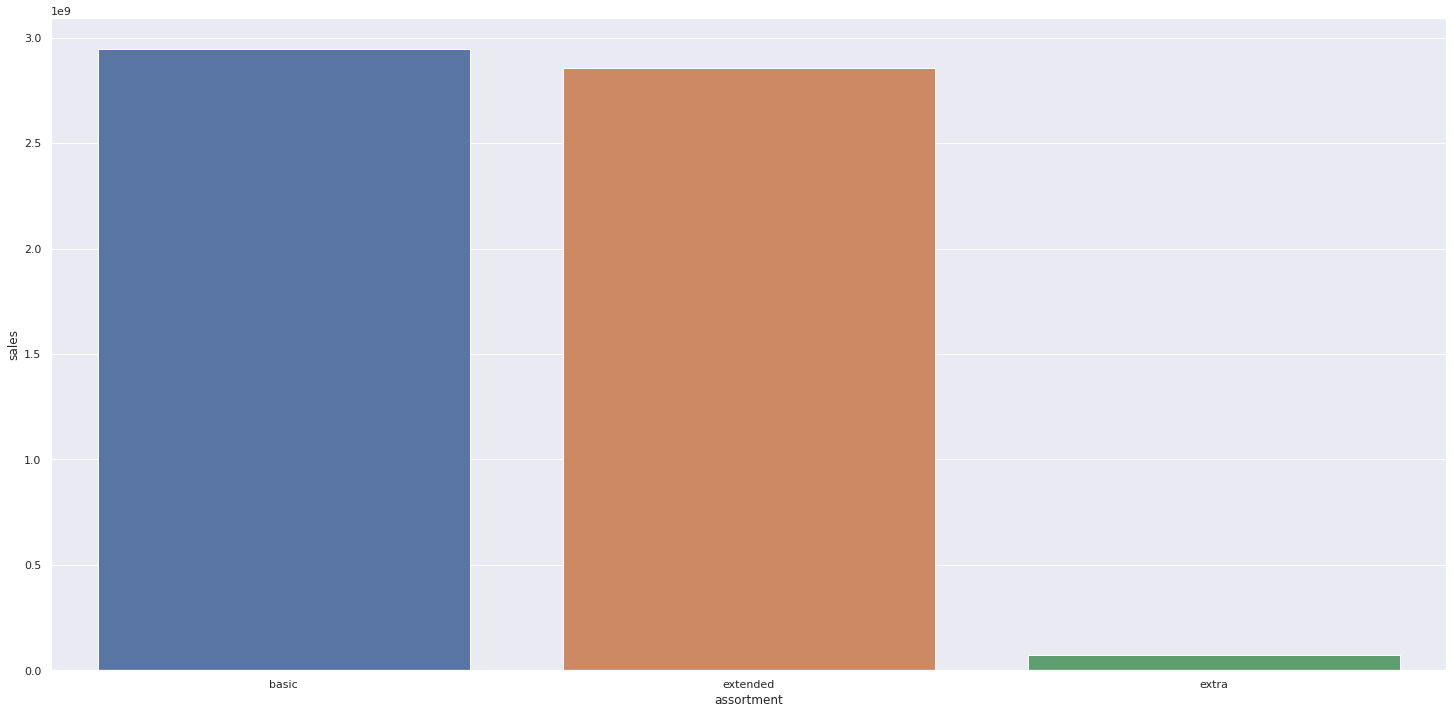

In [51]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

In [52]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


In [53]:
aux3 = aux2.pivot( index='year_week', columns='assortment', values='sales' )
aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


<AxesSubplot:xlabel='year_week'>

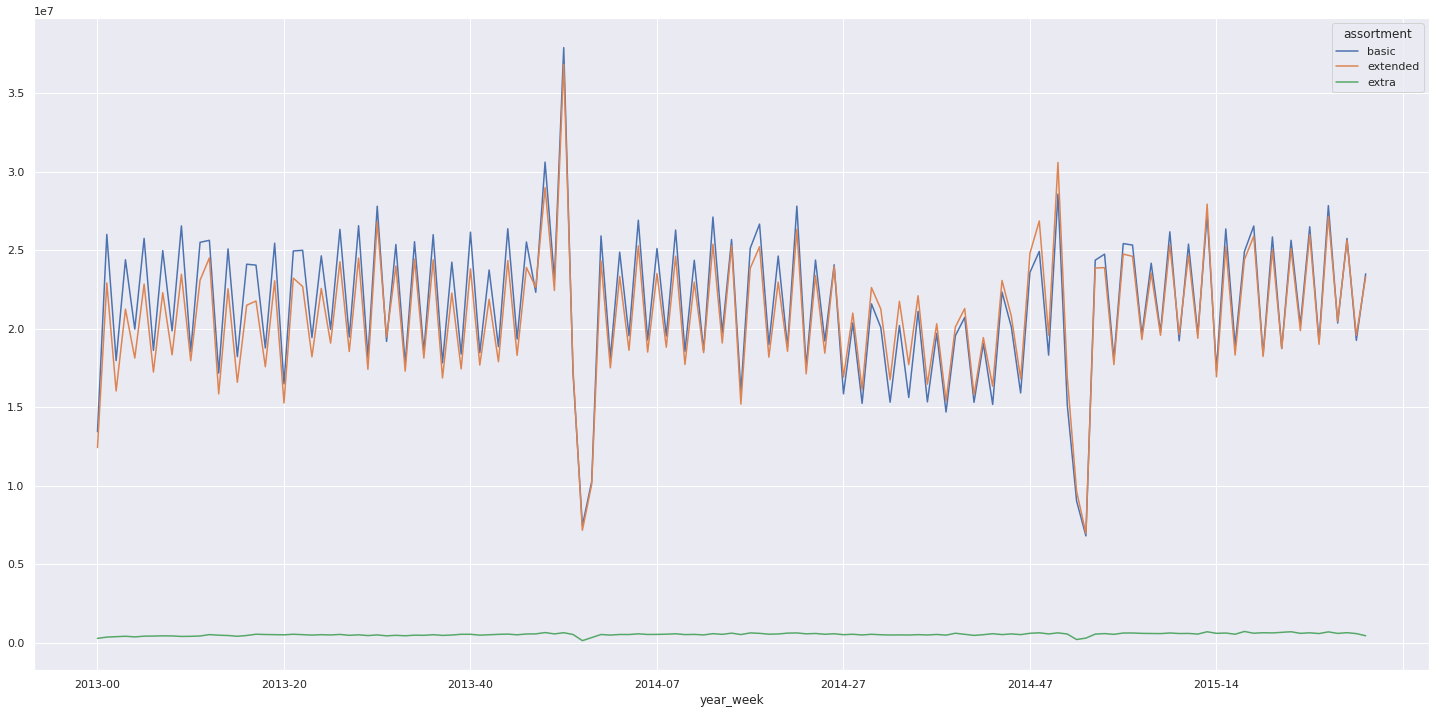

In [54]:
aux3.plot()

<AxesSubplot:xlabel='year_week'>

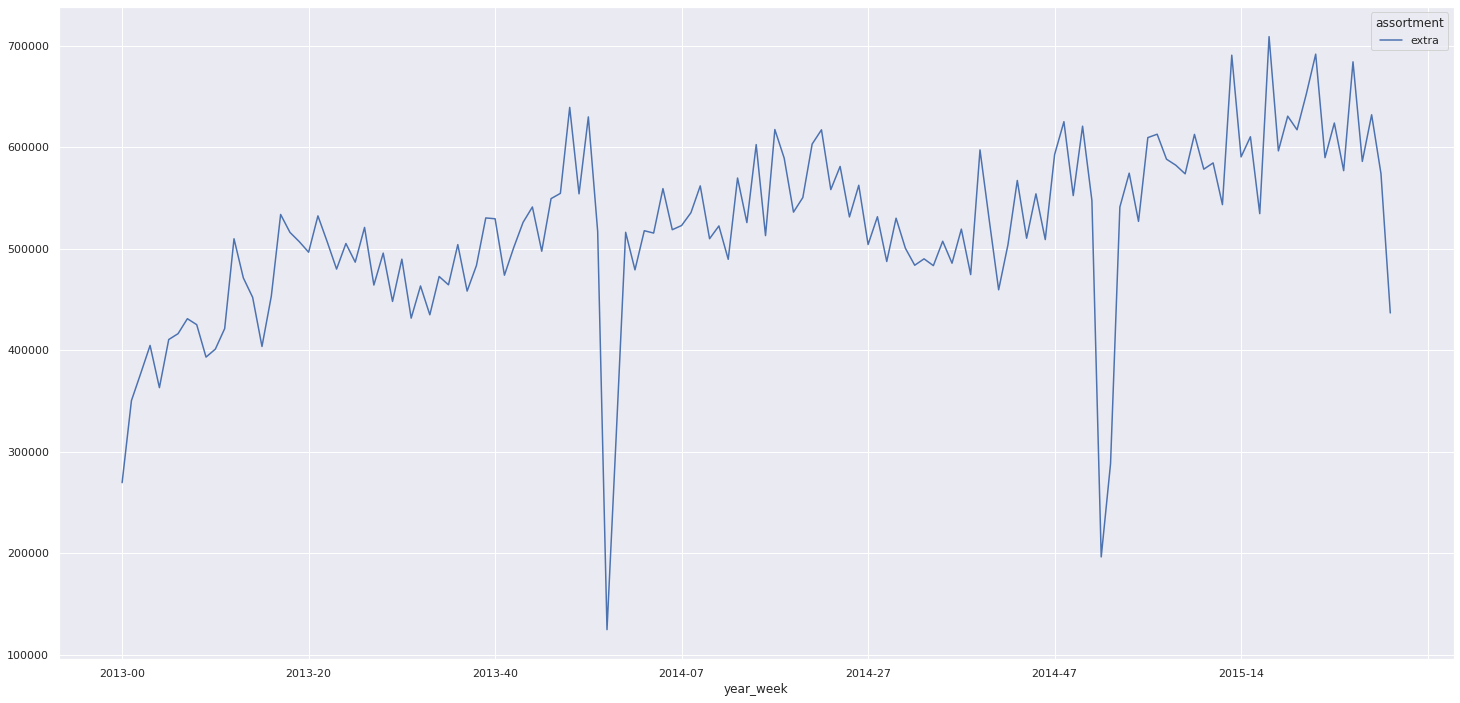

In [55]:
# plotando só o extra separadamente para entender o comportamento e verificar se a escala das outras duas categorias não
# distorceu o comportamento desta
aux4 = aux2[aux2['assortment'] == 'extra']
aux4 = aux4.pivot( index='year_week', columns='assortment', values='sales' )
aux4.plot()

### H2. Lojas com competidores mais próximos deveriam vender menos
***FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

In [56]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

# criando bins para diminuir a granularidade do gráfico
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
40,420.0,32679553,"(0, 1000]"
464,9070.0,12407855,"(9000, 10000]"
352,5140.0,4737388,"(5000, 6000]"
263,3320.0,4253485,"(3000, 4000]"


In [57]:
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()

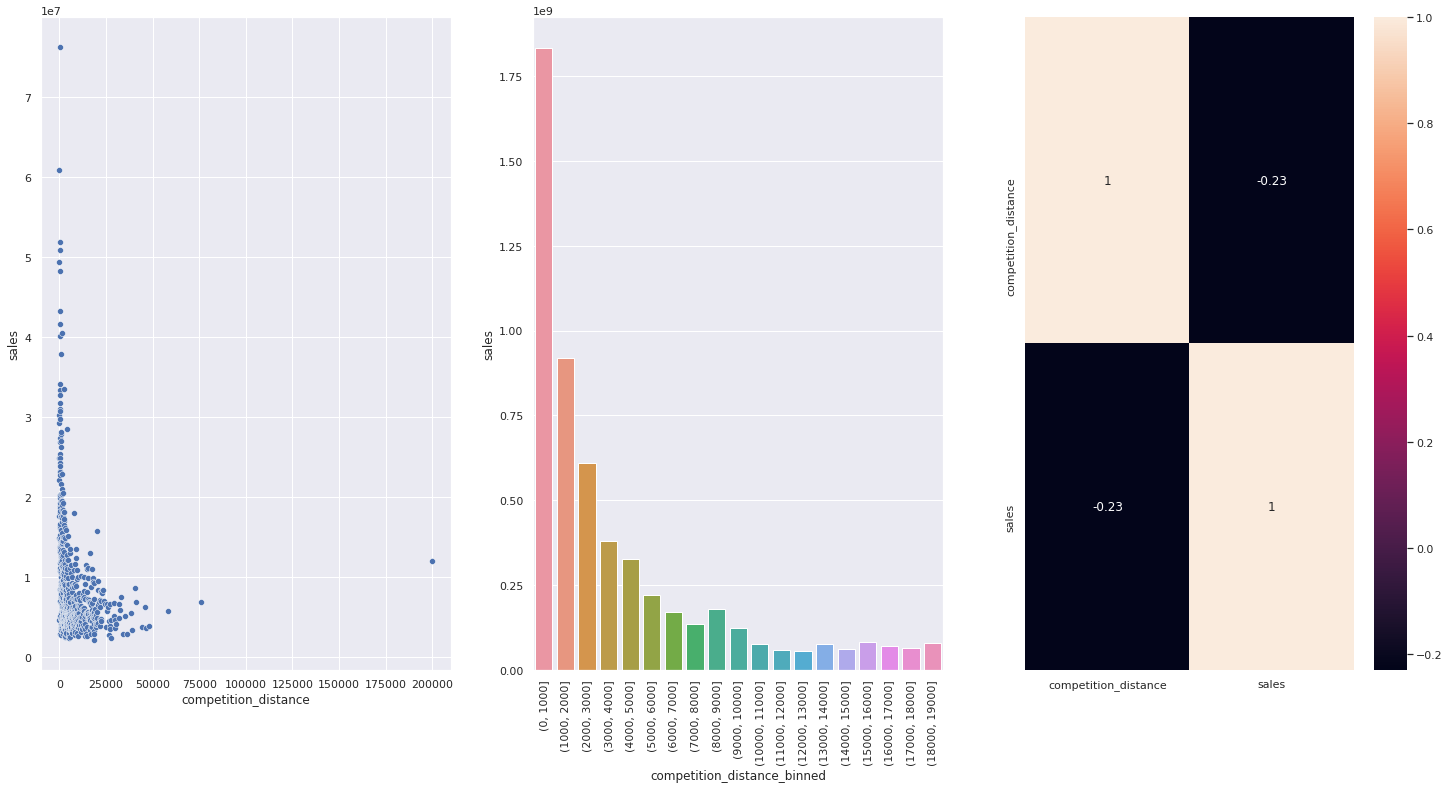

In [58]:
plt.subplot( 1,3,1 )
# para dados muito granulares, o scatterplot também é bastante útil
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot( 1,3,2 )
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 )

plt.subplot( 1,3,3 )
# gráfico que mede a correlação entre as variáveis envolvidas
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H3. Lojas com competidores a mais tempo deveriam vender mais
***FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

<AxesSubplot:xlabel='competition_open_since_month', ylabel='sales'>

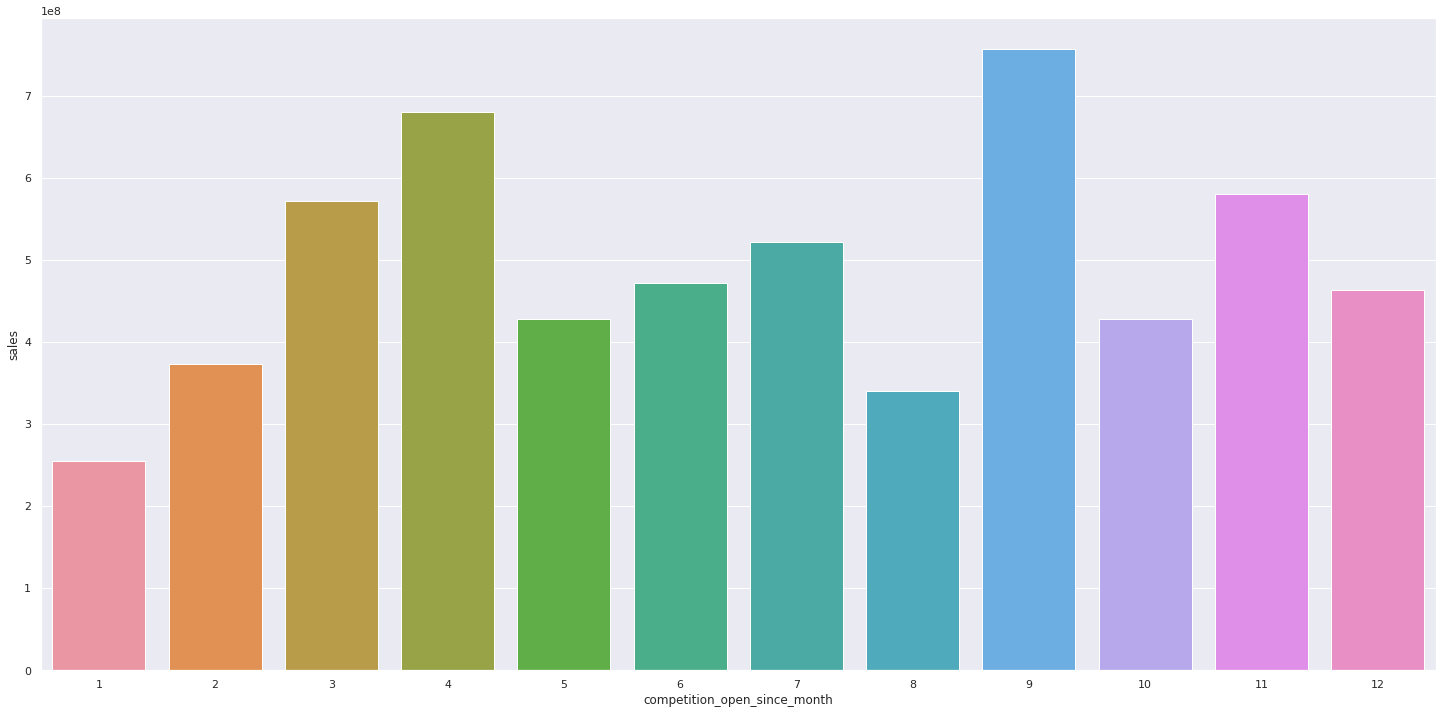

In [59]:
aux1 = df4[['competition_open_since_month','sales']].groupby( 'competition_open_since_month' ).sum().reset_index()
sns.barplot( x='competition_open_since_month', y='sales', data=aux1 )

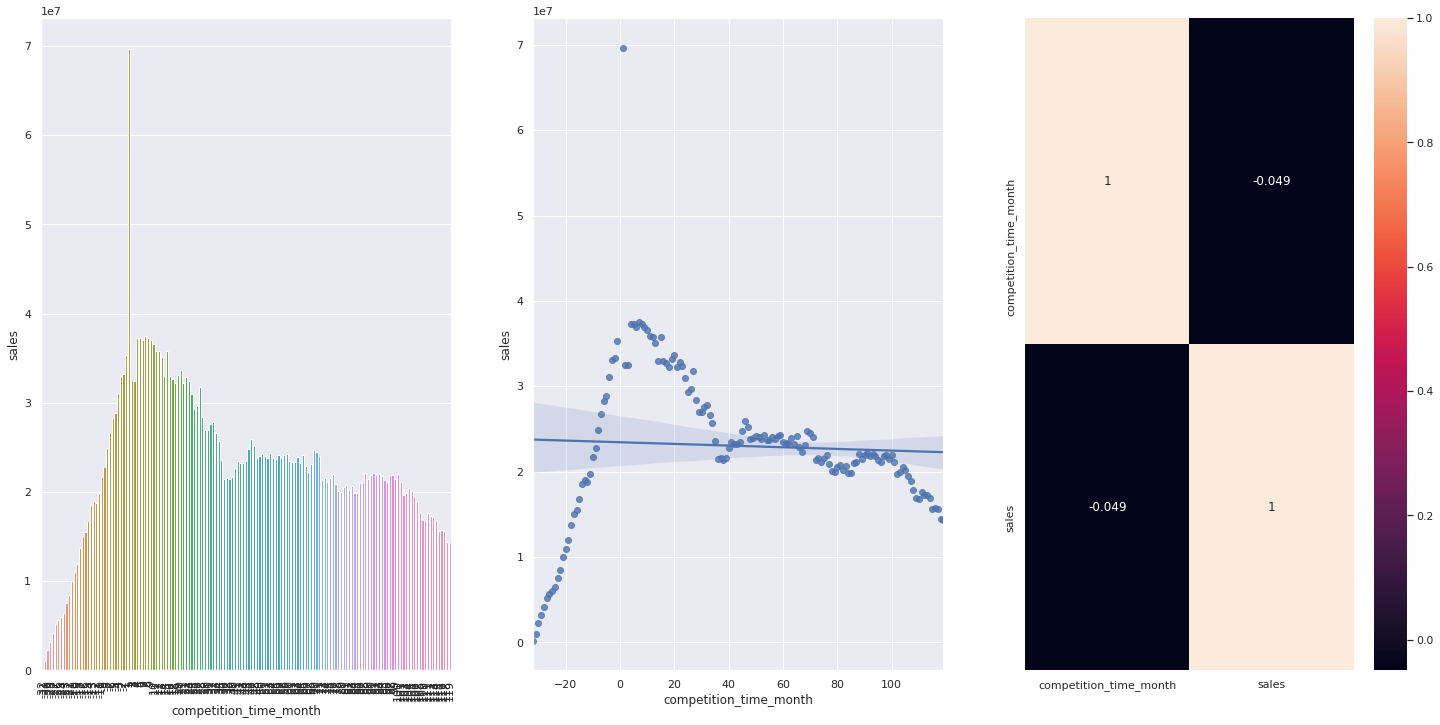

In [60]:
plt.subplot( 1,3,1 )
aux1 = df4[['competition_time_month','sales']].groupby( 'competition_time_month' ).sum().reset_index()
# fazendo um filtro para diminuir a granularidade do dados
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2 )
plt.xticks( rotation=90 );

plt.subplot( 1,3,2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1,3,3 )
sns.heatmap( aux2.corr( method='pearson' ), annot=True );

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
***FALSA** Lojas com CPROMOÇÕES ATIVAS POR MAIS TEMPO, depois de um certo período vendem MENOS

In [61]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


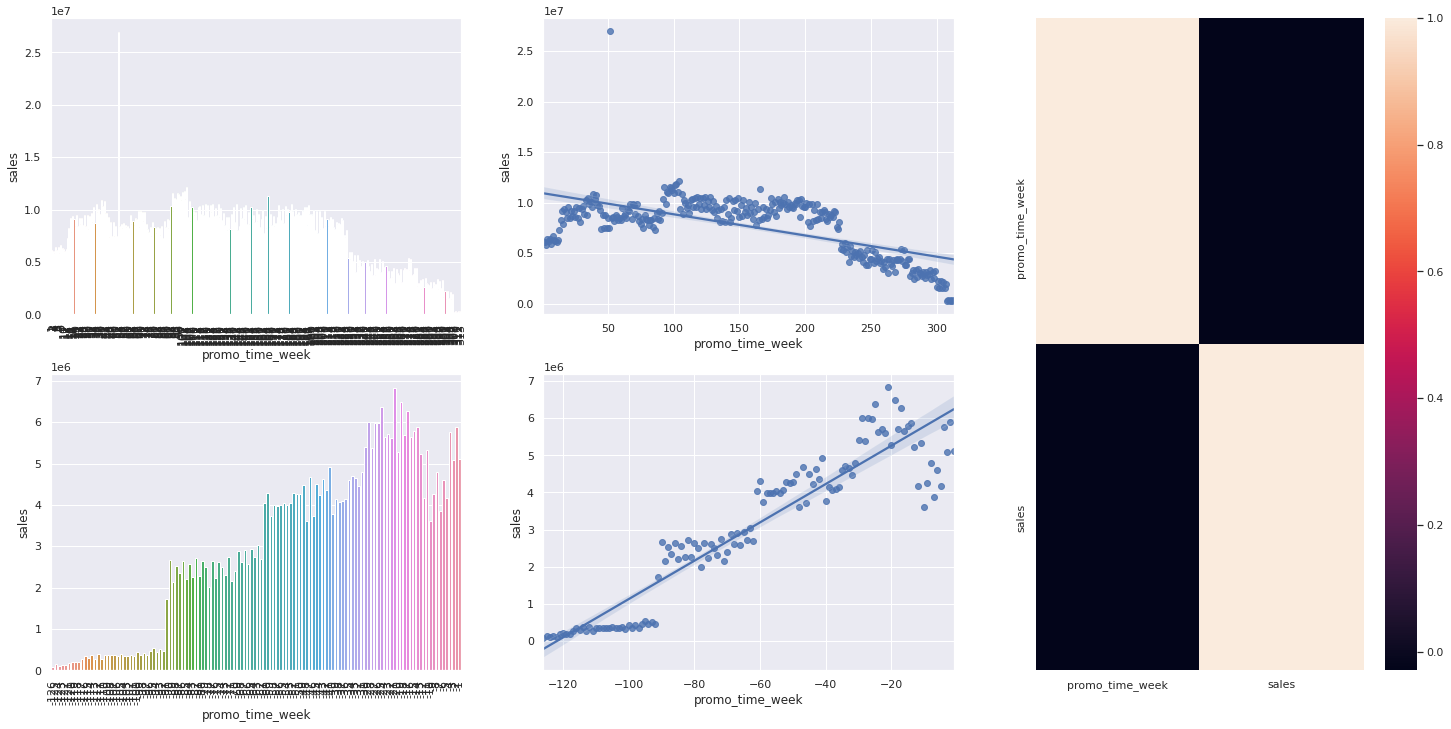

In [67]:
# dimensão de cada linha é uma venda
# hipóteses sobre as dimensões dos dados, pois não sabemos ao certo a documentação dos dados
# existe o período tradicional de promoção ('promo')
# e o período extendido ('promo2')
# a data exata em que começa o período extendido, 'promo_time_week' é usada para calcular o 'promo2_since_*'
# data venda - data início promo2 = 'promo2_since_week' e 'promo2_since_year'
# promo_time_week negativo, significa que foi no período tradicional,  
# se for positivo, está no período extendido, pois a data da venda é posterior ao início do período extendido

aux1 = df4[['promo_time_week','sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = GridSpec( 2,3 )

plt.subplot( grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

demandaria mais uma passada de engenharia de uma feature para poder validar essa hipótese. Vamos deixar para o próximo ciclo do CRISP-DS.
Além disso ela é muito similar à hipótese anterior.

### **H7.** Lojas com mais promoções consecutivas deveriam vender mais.
***FALSA** Lojas com CPROMOÇÕES ATIVAS POR MAIS TEMPO, depois de um certo período vendem MENOS

In [69]:
# 'promo' indica se a loja está no período tradicional promoção.
# 'promo2' indica se a loja está no período extendido promoção.
df4[['promo','promo2','sales']].groupby( ['promo','promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


In [ ]:
# periodo promo regular e extendido
aux1 = df4[(df4['promo'] == 1) & (df4['promo'] == 1)][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

# periodo promo extendido apenas
aux2 = df4[(df4['promo'] == 1) & (df4['promo'] == 0)][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot(ax=ax)

ax.legend( labels=['Tradicional & Extendida','Extendida'] );

## 4.3 Análise Multivariada